In [1]:
from mri_snp_test import MriSnpTest

Using TensorFlow backend.


In [ ]:
csv_file = MriSnpTest(path_to_model='/home/skhorasani/adni/models/CAE_mprage.h5',output_csv='/home/skhorasani/adni/snp_mri_p_part2.csv').test()

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.08s/it]
/home/skhorasani/deep_mmd_testing/deep-mmd-testing/mri_snp_test.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rs_snps = bim[~bim.snp.str.contains(',')][bim.snp.str.contains('rs')].snp


707/707 [==============================] - 48s 67ms/step


In [8]:
snp_mri_test = pd.read_csv('/home/skhorasani/adni/snp_mri_test.csv')

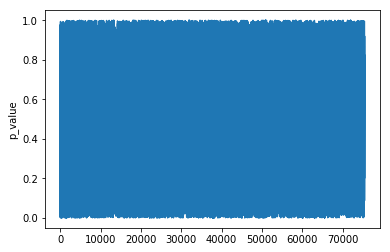

In [12]:
snptest_nodup = snp_mri_test.drop_duplicates(subset='snp')
sns.lineplot(snptest_nodup.index ,snptest_nodup.p_value, )

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas_plink import read_plink
from config_manager import get_directory

In [2]:
snp_p_p1 = pd.read_csv('/home/skhorasani/adni/snp_mri_p.csv')

In [3]:
snp_p_p1.shape

(184778, 6)

In [4]:
snp_p_p1.head()

,snp,p_value,test_condition,x_sample_size,y_sample_size,na_numbers
0,rs35144699,0.037287,AA_vs_Aa,323.0,312.0,0.0
1,rs11103281,0.015134,AA_vs_Aa,548.0,147.0,1.0
2,rs11115650,0.955338,AA_vs_Aa,583.0,113.0,4.0
3,rs11535222,0.623542,AA_vs_Aa,543.0,154.0,1.0
4,rs11586948,0.808035,AA_vs_Aa,528.0,156.0,2.0


In [5]:
snp_p_p2  = pd.read_csv('/home/skhorasani/adni/snp_mri_p_part2.csv')

In [6]:
snp_p_p2.shape

(1077071, 6)

In [3]:
(bim, fam, bed) = read_plink('/mnt/30T/data/ukbiobank/original/genetics/microarray/unzipped/merged/merged.bed')


Mapping files: 100%|██████████| 3/3 [00:56<00:00, 16.99s/it]

In [6]:
len(fam)

488377

In [9]:
(bim, fam, bed) = read_plink(get_directory.adni_bedfile)
rs_snps = bim[~bim.snp.str.contains(',')][bim.snp.str.contains('rs')].snp

Mapping files: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]
/home/skhorasani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [15]:
all_snp_p = pd.merge(snp_p_p1, snp_p_p2, how='outer', on=['snp', 'p_value', 'test_condition', 'x_sample_size', 'y_sample_size', 'na_numbers'])

In [17]:
all_snp_p.shape

(1261849, 6)

In [18]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys

In [26]:
def _qqplot_bar(M=1000000, alphalevel = 0.05,distr = 'log10'):
    '''
    calculate error bars for a QQ-plot
    --------------------------------------------------------------------
    Input:
    -------------   ----------------------------------------------------
    M               number of points to compute error bars
    alphalevel      significance level for the error bars (default 0.05)
    distr           space in which the error bars are implemented
                    Note only log10 is implemented (default 'log10')
    --------------------------------------------------------------------
    Returns:
    -------------   ----------------------------------------------------
    betaUp          upper error bars
    betaDown        lower error bars
    theoreticalPvals    theoretical P-values under uniform
    --------------------------------------------------------------------
    '''


    #assumes 'log10'

    mRange=10**(np.arange(np.log10(0.5),np.log10(M-0.5)+0.1,0.1));#should be exp or 10**?
    numPts=len(mRange);
    betaalphaLevel=np.zeros(numPts);#down in the plot
    betaOneMinusalphaLevel=np.zeros(numPts);#up in the plot
    betaInvHalf=np.zeros(numPts);
    for n in range(numPts):
        m=mRange[n]; #numplessThanThresh=m;
        betaInvHalf[n]=st.beta.ppf(0.5,m,M-m);
        betaalphaLevel[n]=st.beta.ppf(alphalevel,m,M-m);
        betaOneMinusalphaLevel[n]=st.beta.ppf(1-alphalevel,m,M-m);
        pass
    betaDown=betaInvHalf-betaalphaLevel;
    betaUp=betaOneMinusalphaLevel-betaInvHalf;

    theoreticalPvals=mRange/M;
    return betaUp, betaDown, theoreticalPvals


def estimate_lambda(pv):
    '''
    estimate the lambda for a given array of P-values
    ------------------------------------------------------------------
    pv          numpy array containing the P-values
    ------------------------------------------------------------------
    L           lambda value
    ------------------------------------------------------------------
    '''
    LOD2 = np.median(st.chi2.isf(pv, 1))
    L = (LOD2/0.456)
    return L


def qqplot(pvals, fileout = None, alphalevel = 0.05,legend=None,xlim=None,ylim=None,fixaxes=True,addlambda=True,minpval=1e-20,title=None,h1=None,figsize=[5,5],grid=True):
    '''
    performs a P-value QQ-plot in -log10(P-value) space
    -----------------------------------------------------------------------
    Args:
        pvals       P-values, for multiple methods this should be a list (each element will be flattened)
        fileout    if specified, the plot will be saved to the file (optional)
        alphalevel  significance level for the error bars (default 0.05)
                    if None: no error bars are plotted
        legend      legend string. For multiple methods this should be a list
        xlim        X-axis limits for the QQ-plot (unit: -log10)
        ylim        Y-axis limits for the QQ-plot (unit: -log10)
        fixaxes    Makes xlim=0, and ylim=max of the two ylimits, so that plot is square
        addlambda   Compute and add genomic control to the plot, bool
        title       plot title, string (default: empty)
        h1          figure handle (default None)
        figsize     size of the figure. (default: [5,5])
        grid        boolean: use a grid? (default: True)
    Returns:   fighandle, qnull, qemp
    -----------------------------------------------------------------------
    '''    
    distr = 'log10'
    import pylab as pl
    if type(pvals)==list:
        pvallist=pvals
    else:
        pvallist = [pvals]
    if type(legend)==list:
        legendlist=legend
    else:
        legendlist = [legend]
    
    if h1 is None:
        h1=plt.figure(figsize=figsize) 
    
    pl.grid(b=grid, alpha = 0.5)
         
    maxval = 0.0

    for i in range(len(pvallist)):        
        pval =pvallist[i].flatten()
        M = pval.shape[0]
        pnull = (0.5 + np.arange(M))/M
        # pnull = np.sort(np.random.uniform(size = tests))
                
        pval[pval<minpval]=minpval
        pval[pval>=1]=1

        if distr == 'chi2':
            qnull = st.chi2.isf(pnull, 1)
            qemp = (st.chi2.isf(sp.sort(pval),1))
            xl = 'LOD scores'
            yl = '$\chi^2$ quantiles'

        if distr == 'log10':
            qnull = -np.log10(pnull)            
            qemp = -np.log10(np.sort(pval)) #sorts the object, returns nothing
            xl = '-log10(P) observed'
            yl = '-log10(P) expected'
        if not (np.isreal(qemp)).all(): raise Exception("imaginary qemp found")
        if qnull.max()>maxval:
            maxval = qnull.max()                
        plt.plot(qnull, qemp, '.', markersize=2)
        #pl.plot([0,qemp.max()], [0,qemp.max()],'r')        
        if addlambda:
            lambda_gc = estimate_lambda(pval)
            print ("lambda=%1.4f" % lambda_gc)
            #pl.legend(["gc="+ '%1.3f' % lambda_gc],loc=2)   
            # if there's only one method, just print the lambda
            if len(pvallist) == 1:
                legendlist=["$\lambda_{GC}=$%1.4f" % lambda_gc]   
            # otherwise add it at the end of the name
            else:
                legendlist[i] = legendlist[i] + " ($\lambda_{GC}=$%1.4f)" % lambda_gc

    addqqplotinfo(qnull,M,xl,yl,xlim,ylim,alphalevel,legendlist,fixaxes)  
    
    if title is not None:
        plt.title(title)            
    
    if fileout is not None:
        plt.savefig(fileout)

    return h1,qnull, qemp,


def fix_axes(buffer=0.1):
    '''
    Makes x and y max the same, and the lower limits 0.
    '''    
    maxlim=max(plt.xlim()[1],plt.ylim()[1])    
    plt.xlim([0-buffer,maxlim+buffer])
    plt.ylim([0-buffer,maxlim+buffer])


def addqqplotinfo(qnull,M,xl='-log10(P) observed',yl='-log10(P) expected',xlim=None,ylim=None,alphalevel=0.05,legendlist=None,fixaxes=False):    
    distr='log10'
    plt.plot([0,qnull.max()], [0,qnull.max()],'k')
    plt.ylabel(xl)
    plt.xlabel(yl)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)        
    if alphalevel is not None:
        if distr == 'log10':
            betaUp, betaDown, theoreticalPvals = _qqplot_bar(M=M,alphalevel=alphalevel,distr=distr)
            lower = -np.log10(theoreticalPvals-betaDown)
            upper = -np.log10(theoreticalPvals+betaUp)
            plt.fill_between(-np.log10(theoreticalPvals),lower,upper,color="grey",alpha=0.5)
            #pl.plot(-sp.log10(theoreticalPvals),lower,'g-.')
            #pl.plot(-sp.log10(theoreticalPvals),upper,'g-.')
    if legendlist is not None:
        leg = plt.legend(legendlist, loc=4, numpoints=1)
        # set the markersize for the legend
        for lo in leg.legendHandles:
            lo.set_markersize(10)

    if fixaxes:
        fix_axes()

def manhattan_plot(chr_pos_pvalue_array,pvalue_line=None,plot_threshold=1.0,vline_significant=False,marker="o", chromosome_starts=None, xaxis_unit_bp=True, alpha=0.5):
    """
    Function to create a Manhattan plot.  See http://en.wikipedia.org/wiki/Manhattan_plot.

    Args:
        chr_pos_pvalue_array:   an n x 3 numpy array. The three columns are the chrom number 
                                (as a number), the position, and pvalue.
                                :type chr_pos_pvalue_array: numpy array
        pvalue_line:            (Default: None). If given, draws a line at that PValue.
                                :type pvalue_line: a 'pheno dictionary' or a string
        plot_threshold:         plot only SNPs that achieve a P-value smaller than pvalue_threshold
                                to speed up plotting
        vline_significant:      boolean. Draw a vertical line at each significant Pvalue?
                                :rtype: none, but changes the global current figure.
        marker:                 marker for the scatter plot. default: "o"
        chromosome_starts:      [Nchrom x 3] ndarray: chromosome, cumulative start position, cumulative stop position
                                cumulative chromosome starts, for plotting. If None (default), this is estimated from data
        xaxis_unit_bp:          plot cumulative position in basepair units on x axis? If False, only 
                                use rank of SNP positions. (default: True)
        alpha:                  alpha (opaquness) for P-value markers in scatterplot (default 0.5)

    Returns:
        chromosome_starts       [Nchrom x 3] ndarray: chromosome, cumulative start position, cumulative stop position
                                cumulative chromosome starts used in plotting.

    :Example:

    >>> from fastlmm.association import single_snp
    >>> from pysnptools.snpreader import Bed
    >>> import matplotlib.pyplot as plt
    >>> import fastlmm.util.util as flutil
    >>> pheno_fn = "../feature_selection/examples/toydata.phe"
    >>> results_dataframe = single_snp(test_snps="../feature_selection/examples/toydata.5chrom", pheno=pheno_fn, h2=.2, count_A1=False)
    >>> #chromosome_starts = flutil.manhattan_plot(results_dataframe[["Chr", "ChrPos", "PValue"]],pvalue_line=1e-7)
    >>> #plt.show()

    """
    # import matplotlib
    # matplotlib.use('Agg',warn=False) #This lets it work even on machines without graphics displays
    # import matplotlib.pyplot as plt

    # create a copy of the data and sort it by chrom and then position
    array = np.array(chr_pos_pvalue_array)
    if plot_threshold:
        array = array[array[:,2]<=plot_threshold]
    else:
        plot_threshold = 1.0
    array=array[np.argsort(array[:,1]),:] #sort by ChrPos
    array=array[np.argsort(array[:,0],kind='mergesort'),:] #Finally, sort by Chr (but keep ChrPos in case of ties)
    rle = list(_run_length_encode(array[:,0]))
        
    if xaxis_unit_bp:   #compute and use cumulative basepair positions for x-axis
        if chromosome_starts is None:
            chromosome_starts = _compute_x_positions_chrom(array)
        chr_pos_list = _compute_x_positions_snps(array, chromosome_starts)
        plt.xlim([0,chromosome_starts[-1,2]+1])
        plt.xticks(chromosome_starts[:,1:3].mean(1),chromosome_starts[:,0])
    else:               #use rank indices for x-axis
        chr_pos_list = np.arange(array.shape[0])
        xTickMarks = [str(int(item)) for item,count in rle]
        plt.xlim([0,array.shape[0]])
        plt.xticks(list(_rel_to_midpoint(rle)), xTickMarks)
    y = -np.log10(array[:,2])
    max_y = y.max()

    if pvalue_line and vline_significant:   #mark significant associations (ones that pass the pvalue_line) by a red vertical line:
        idx_significant = array[:,2]<pvalue_line
        if np.any(idx_significant):
            y_significant = y[idx_significant]
            chr_pos_list_significant = chr_pos_list[idx_significant]
            for i in range(len(chr_pos_list_significant)):
                plt.axvline(x=chr_pos_list_significant[i],ymin = 0.0, ymax = y_significant[i], color = 'r',alpha=0.8)

    plt.scatter(chr_pos_list,y,marker=marker,c=_color_list(array[:,0],rle),edgecolor='none',s=y/max_y*20+0.5, alpha=alpha)
    plt.xlabel("chromosome")
    plt.ylabel("-log10(P value)")

    if pvalue_line:
        plt.axhline(-np.log10(pvalue_line),linestyle="--",color='gray')
    plt.ylim([-np.log10(plot_threshold),None])
    return chromosome_starts

def _compute_x_positions_chrom(positions, offset=1e5):
    chromosomes = np.unique(positions[:,0])
    chromosomes.sort()
    chromosome_starts = np.zeros((chromosomes.shape[0],3),dtype="object")
    chr_start_next = 0
    for i, chromosome in enumerate(chromosomes):
        pos_chr = positions[positions[:,0]==chromosome]
        chromosome_starts[i,0] = chromosome                     #the chromosome
        chromosome_starts[i,1] = chr_start_next                 #start of the chromosome
        chromosome_starts[i,2] = chr_start_next + pos_chr.max() #end of the chromosome
        chr_start_next = chromosome_starts[i,2] + offset
    return chromosome_starts

def _compute_x_positions_snps(positions, chromosome_starts):
    cumulative_pos = np.zeros(positions.shape[0])
    for i, chromosome_start in enumerate(chromosome_starts):
        idx_chr = positions[:,0]==chromosome_start[0]
        cumulative_pos[idx_chr] = positions[idx_chr][:,1] + chromosome_start[1]
    return cumulative_pos

def _rel_to_midpoint(rle):
    previous_count = 0
    for item, count in rle:
        yield previous_count + count // 2
        previous_count += count

def _run_length_encode(seq):
    count = 0
    previous = None
    for item in seq:
        if count == 0:
            count = 1
            previous = item
        elif item == previous:
            count += 1
        else:
            yield previous, count
            previous = item
            count =1
    if count > 0:
        yield previous, count

def _color_list(chr_list,rle):
    chr_to_index = dict((chr,index) for index,(chr,count) in enumerate(rle))
    index_to_color = {0:"b",1:"g"}
    result = [index_to_color[chr_to_index[chr]%len(index_to_color)] for chr in chr_list]
    return result

In [22]:
all_snp_p.to_csv('/home/skhorasani/adni/deepmmed_gwas.csv', index=False)

In [37]:
data = pd.read_csv('/home/skhorasani/adni/deepmmed_gwas.csv', index_col="snp")
data = data[data.p_value != 0]

bimfile = pd.read_csv("/home/skhorasani/adni/adni_snp_filtered/WGS_Omni25_BIN_wo_ConsentsIssues_filtered.bim", sep="\t", header=None, index_col=1,names=["chr","snp","gdist","pos","A1","A2"])

data_merged = data.merge(bimfile,left_index=True,right_index=True)

data_autosomes = data_merged[data_merged.chr<23]

lambda=1.1482


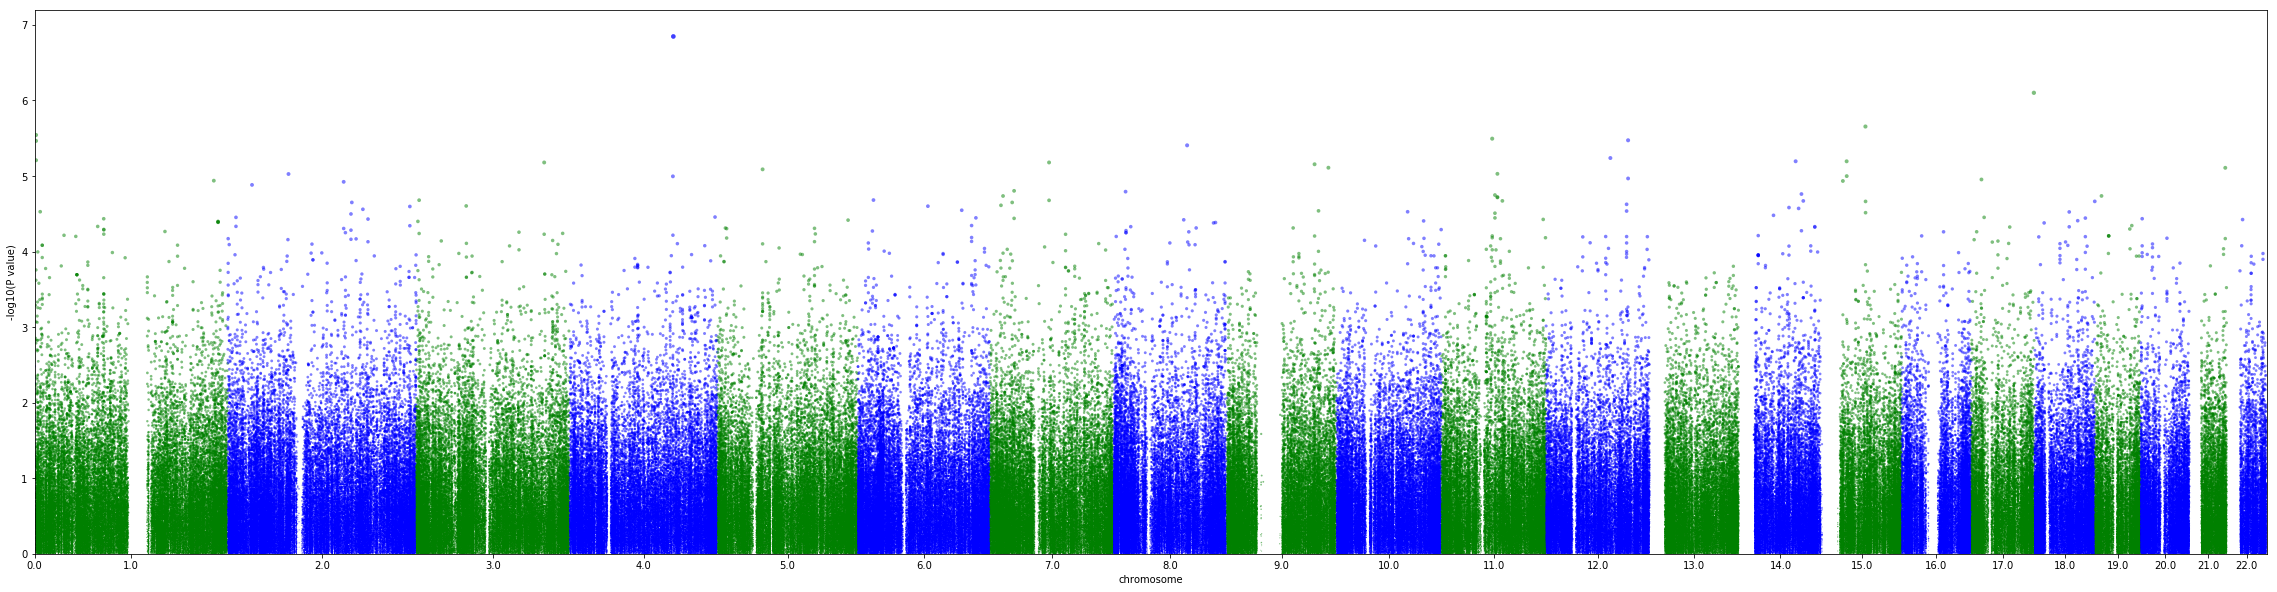

<Figure size 720x720 with 0 Axes>

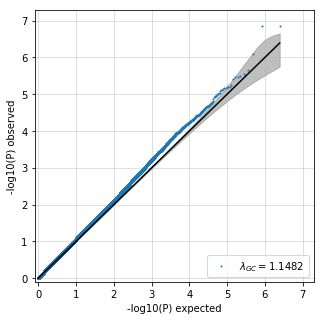

In [38]:
data_autosomes = data_merged[data_merged.chr<23]
ax = plt.figure(figsize=(40,10))

manhattan_plot(chr_pos_pvalue_array=data_autosomes[["chr","pos","p_value"]],pvalue_line=None,plot_threshold=1.0,vline_significant=False,marker="o", chromosome_starts=None, xaxis_unit_bp=True, alpha=0.5)

plt.savefig("/home/skhorasani/adni/manhattan_autosomes.png")


ax2 = plt.figure(figsize=(10,10))
qqplot(data_autosomes[["p_value"]].values, fileout = None, alphalevel = 0.05,legend=None,xlim=None,ylim=None,fixaxes=True,addlambda=True,minpval=1e-20,title=None,h1=None,figsize=[5,5],grid=True)
plt.savefig("/home/skhorasani/adni/qqplot_autosomes.png")

lambda=1.1950


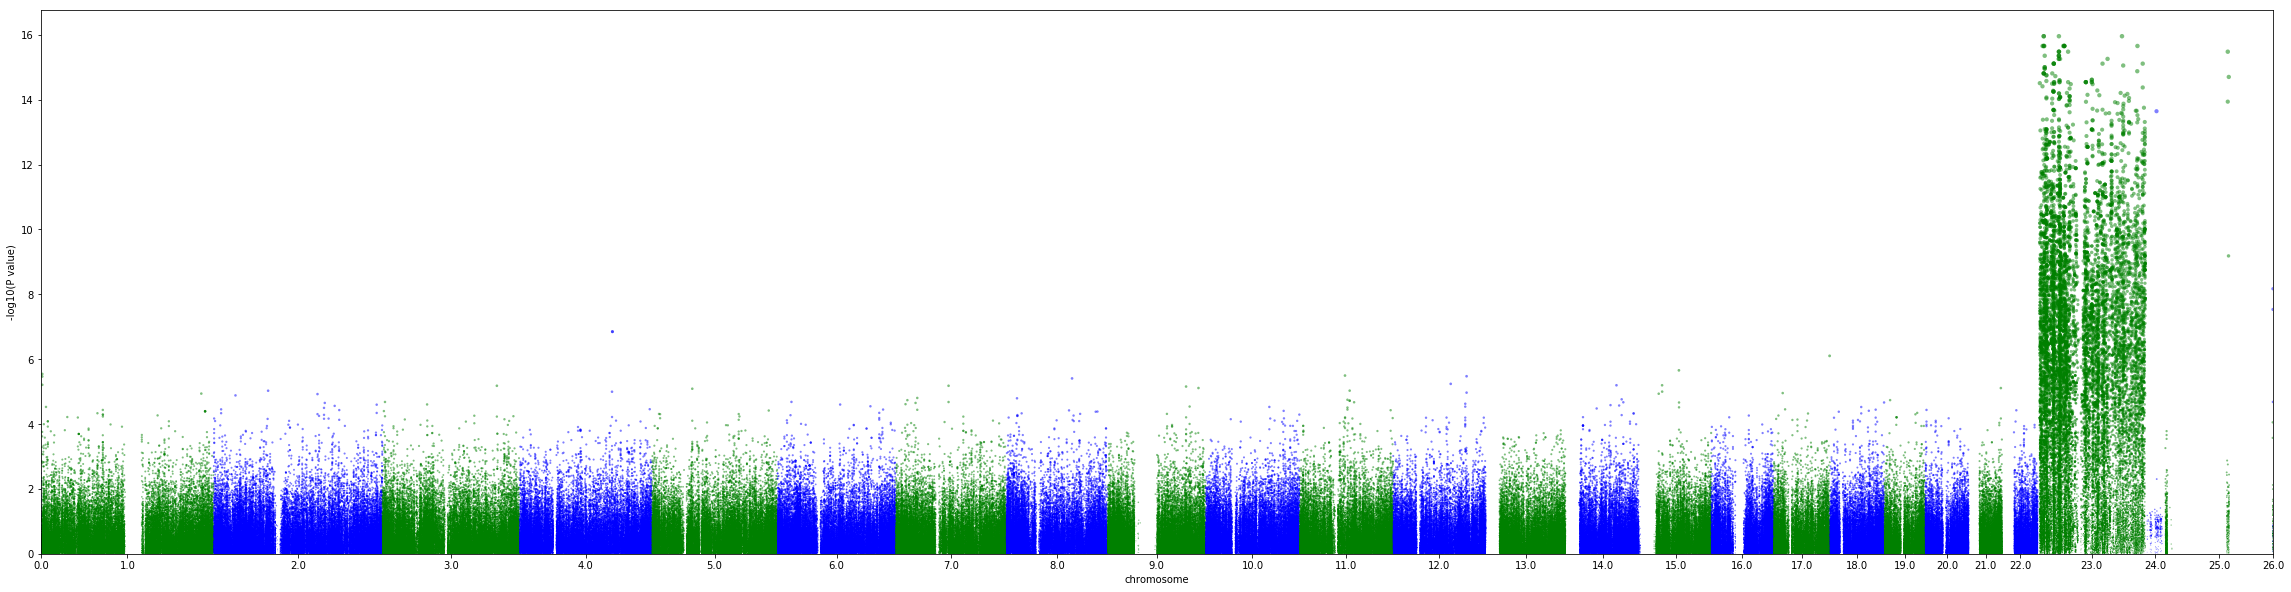

<Figure size 720x720 with 0 Axes>

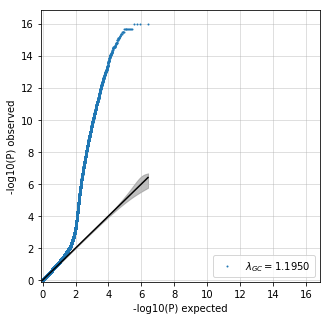

In [39]:
ax = plt.figure(figsize=(40,10))

manhattan_plot(chr_pos_pvalue_array=data_merged[["chr","pos","p_value"]],pvalue_line=None,plot_threshold=1.0,vline_significant=False,marker="o", chromosome_starts=None, xaxis_unit_bp=True, alpha=0.5)

plt.savefig("/home/skhorasani/adni/manhattan_autosomes_with_sexChro.png")


ax2 = plt.figure(figsize=(10,10))
qqplot(data_merged[["p_value"]].values, fileout = None, alphalevel = 0.05,legend=None,xlim=None,ylim=None,fixaxes=True,addlambda=True,minpval=1e-20,title=None,h1=None,figsize=[5,5],grid=True)
plt.savefig("/home/skhorasani/adni/qqplot_autosomes_sexChro.png")